In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

import os
# Use this to see how much memory the dataframes use
from sys import getsizeof

import yaml

import pseudopeople as pp
from pseudopeople.utilities import get_configuration
from vivarium.framework.randomness import RandomnessStream

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Fri 31 Mar 2023 02:28:42 PM PDT
ndbs
Linux int-slurm-sarchive-p0005 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/model_validation


In [2]:
%load_ext autoreload
%autoreload 2

# Questions and comments

1. What does "base" mean in the configuration tree?
1. What does "source" mean in the config tree? Presumably this is whether it's the default value or a user-provided value?
1. Is there an easier way to work with the ConfigTree?
1. It would be nice to be able to pass a dataframe instead of a file path so I don't have to load the data multiple times.
1. Do we want empty strings or NaNs for missing data?
1. I'd like to be able to easily call the noise functions on individual Series for testing.
1. Do we want the function to return all census years, or one year at a time?
1. 

# Find Zeb's data

```
/ihme/scratch/users/zmbc/vivarium_results/united_states_of_america/2023_03_20_11_09_48/final_results/2023_03_20_12_31_44
```

In [3]:
zeb_output_dir = \
    '/ihme/scratch/users/zmbc/vivarium_results'
zeb_output_subdir = (
    '/united_states_of_america/2023_03_20_11_09_48'
    '/final_results/2023_03_20_12_31_44'
)
sample_data_dir = f'{zeb_output_dir}{zeb_output_subdir}'

!ls -halt $sample_data_dir

total 40K
drwxrwxr-x  8 zmbc Domain Users 3.5K Mar 20 12:35 ..
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 tax_dependents_observer
drwxrwxr-x 10 zmbc Domain Users 4.0K Mar 20 12:35 .
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 tax_1040_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 tax_w2_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 social_security_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 wic_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 household_survey_observer_cps
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 household_survey_observer_acs
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 decennial_census_observer


In [4]:
!ls -halt $sample_data_dir/decennial_census_observer

total 504K
drwxrwxr-x 10 zmbc Domain Users 4.0K Mar 20 12:35 ..
-rwxr-xr-x  1 zmbc Domain Users 490K Mar 20 12:35 decennial_census_observer.csv.bz2
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 .


# Load Zeb's decennial census data

In [5]:
census_dir = f'{sample_data_dir}/decennial_census_observer'
census_path = f'{census_dir}/decennial_census_observer.csv.bz2'

In [6]:
%%time
df_census = pd.read_csv(census_path)
df_census

CPU times: user 195 ms, sys: 19.5 ms, total: 214 ms
Wall time: 218 ms


,middle_initial,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,relation_to_household_head,sex,zipcode,race_ethnicity,last_name,year,street_number,street_name,guardian_2,first_name
0,M,USA,76.024932,Standard,Anytown,1944-03-23,0_4,NaN,0_-1,Reference person,Female,90210,Black,Shipp,2020,1312,commonwealth avnue,0_-1,Maureen
1,N,USA,69.075260,Standard,Anytown,1951-03-05,0_5,NaN,0_-1,Opp-sex spouse,Male,90210,Black,Shipp,2020,1312,commonwealth avnue,0_-1,Richard
2,C,USA,66.661179,Standard,Anytown,1953-08-03,0_2464,NaN,0_-1,Reference person,Female,90210,Black,Holt,2020,46,bancroft st,0_-1,Darlene
3,S,USA,42.860033,Standard,Anytown,1977-05-22,0_3558,NaN,0_-1,Reference person,Female,90210,Black,Holt,2020,9112,janis ne,0_-1,Tabatha
4,M,USA,25.293532,Standard,Anytown,1994-12-16,0_3559,NaN,0_-1,Biological child,Female,90210,Black,Holt,2020,9112,janis ne,0_-1,Alice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19949,S,USA,66.493182,Standard,Anytown,1963-09-21,0_17995,NaN,0_-1,Reference person,Male,90210,White,Wasser,2030,5700,n cr 400 e,0_-1,John
19950,K,USA,77.426139,Standard,Anytown,1952-10-15,0_18073,NaN,0_-1,Reference person,Male,90210,Black,Hughes,2030,21,mammoth springs dr,0_-1,Clyde
19951,C,USA,2.432617,Standard,Anytown,2027-11-11,0_22588,NaN,0_14366,Reference person,Female,90210,Black,Walker,2030,8728,high pine meadows r,0_-1,Stephanie
19952,D,USA,23.517320,Standard,Anytown,2006-10-10,0_22759,NaN,0_-1,Reference person,Male,90210,White,Foster,2030,1900,ranch loop,0_-1,Austin


In [7]:
seed = 33
%time df_census_noisy = pp.generate_decennial_census(census_path, seed)
df_census_noisy

CPU times: user 244 ms, sys: 13.9 ms, total: 258 ms
Wall time: 259 ms


,middle_initial,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,relation_to_household_head,sex,zipcode,race_ethnicity,last_name,year,street_number,street_name,guardian_2,first_name
0,M,USA,76.024932,Standard,Anytown,1944-03-23,0_4,NaN,0_-1,Reference person,Female,90210,Black,Shipp,2020,1312,commonwealth avnue,0_-1,Maureen
1,N,USA,69.07526,Standard,Anytown,1951-03-05,0_5,NaN,0_-1,Opp-sex spouse,Male,90210,Black,Shipp,2020,1312,commonwealth avnue,0_-1,Richard
2,C,USA,66.661179,Standard,Anytown,1953-08-03,0_2464,NaN,0_-1,Reference person,Female,90210,Black,Holt,2020,46,bancroft st,0_-1,Darlene
3,S,USA,42.860033,Standard,Anytown,1977-05-22,0_3558,NaN,0_-1,Reference person,Female,90210,Black,Holt,2020,9112,janis ne,0_-1,Tabatha
4,M,USA,25.293532,Standard,Anytown,1994-12-16,0_3559,NaN,0_-1,Biological child,Female,90210,Black,Holt,2020,9112,janis ne,0_-1,Alice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19949,S,USA,66.493182,Standard,Anytown,1963-09-21,0_17995,NaN,0_-1,Reference person,Male,90210,White,Wasser,2030,5700,n cr 400 e,0_-1,John
19950,K,USA,77.426139,Standard,Anytown,1952-10-15,0_18073,NaN,0_-1,Reference person,Male,90210,Black,Hughes,2030,21,mammoth springs dr,0_-1,Clyde
19951,C,,2.432617,Standard,Anytown,2027-11-11,0_22588,NaN,0_14366,Reference person,Female,90210,Black,Walker,2030,,high pine meadows r,0_-1,Stephanie
19952,D,USA,23.51732,Standard,Anytown,2006-10-10,0_22759,NaN,0_-1,Reference person,Male,90210,White,Foster,2030,1900,ranch loop,0_-1,Austin


In [8]:
df_census.compare(df_census_noisy)

middle_initial       state        age       housing_type           city  \
                self other  self other self other         self other     self   
6                  C         NaN   NaN  NaN   NaN          NaN   NaN      NaN   
8                NaN   NaN   USA        NaN   NaN          NaN   NaN      NaN   
11               NaN   NaN   NaN   NaN  NaN   NaN          NaN   NaN      NaN   
31               NaN   NaN   NaN   NaN  NaN   NaN          NaN   NaN      NaN   
44               NaN   NaN   NaN   NaN  NaN   NaN          NaN   NaN      NaN   
...              ...   ...   ...   ...  ...   ...          ...   ...      ...   
19919            NaN   NaN   NaN   NaN  NaN   NaN          NaN   NaN      NaN   
19928            NaN   NaN   NaN   NaN  NaN   NaN     Standard            NaN   
19933            NaN   NaN   NaN   NaN  NaN   NaN          NaN   NaN  Anytown   
19940            NaN   NaN   NaN   NaN  NaN   NaN     Standard            NaN   
19951            NaN   NaN   USA        NaN   NaN          NaN   NaN      NaN   

             ... race_ethnicity       last_name       street_number        \
      other  ...           self other      self other          self other   
6       NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
8       NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
11      NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
31      NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
44      NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
...     ...  ...            ...   ...       ...   ...           ...   ...   
19919   NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
19928   NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
19933        ...            NaN   NaN     Rubio                 NaN   NaN   
19940   NaN  ...            NaN   NaN       NaN   NaN           NaN   NaN   
19951   NaN  ...            NaN   NaN       NaN   NaN          8728         

          street_name       first_name        
                 self other       self other  
6                 NaN   NaN        NaN   NaN  
8                 NaN   NaN        NaN   NaN  
11          cir dr se              NaN   NaN  
31                NaN   NaN        NaN   NaN  
44                NaN   NaN        NaN   NaN  
...               ...   ...        ...   ...  
19919             NaN   NaN        NaN   NaN  
19928  n sunshine cir              NaN   NaN  
19933    ocean avenue              NaN   NaN  
19940             NaN   NaN        NaN   NaN  
19951             NaN   NaN        NaN   NaN  

[2700 rows x 30 columns]

# Create "cleaned" noisy data by replacing empty strings with NaN

# Then count how many values are missing in each column

In [9]:
%time df_census_noisy_clean = df_census_noisy.replace('', np.nan)
%time missing_totals = df_census_noisy_clean.isna().sum()
missing_totals

CPU times: user 11.9 ms, sys: 3.95 ms, total: 15.9 ms
Wall time: 14.7 ms
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.7 ms


middle_initial                  205
state                           172
age                             202
housing_type                    204
city                            179
date_of_birth                   172
simulant_id                       0
unit_number                   18916
guardian_1                        0
relation_to_household_head      193
sex                             183
zipcode                         211
race_ethnicity                  185
last_name                       176
year                              0
street_number                   986
street_name                     190
guardian_2                        0
first_name                      203
dtype: int64

In [10]:
len(df_census)

19954

# Compute fraction of values missing in each column and compare to what's in the default configuration

It looks like everything should be missing with probability 0.01, except that some things like `unit_number` already had a lot of missing values.

List of columns with `row_noise_level` set to 0.01 (see code below to generate this):

```python
['first_name',
 'middle_initial',
 'last_name',
 'age',
 'date_of_birth',
 'street_number',
 'street_name',
 'unit_number',
 'city',
 'state',
 'zipcode',
 'relation_to_household_head',
 'sex',
 'race_ethnicity',
 'housing_type']
```

In [11]:
missing_totals / len(df_census)

middle_initial                0.010274
state                         0.008620
age                           0.010123
housing_type                  0.010224
city                          0.008971
date_of_birth                 0.008620
simulant_id                   0.000000
unit_number                   0.947980
guardian_1                    0.000000
relation_to_household_head    0.009672
sex                           0.009171
zipcode                       0.010574
race_ethnicity                0.009271
last_name                     0.008820
year                          0.000000
street_number                 0.049414
street_name                   0.009522
guardian_2                    0.000000
first_name                    0.010173
dtype: float64

In [12]:
config_tree = get_configuration()
config_tree

decennial_census:
    omission:
        base: 0.0145
            source: initial data
    duplication:
        base: 0.05
            source: initial data
    first_name:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
    middle_initial:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
    last_name:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
    age:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
    date_of_birth:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
    street_number:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
    street_name:
        missing_

# Experiment with ConfigTree -- try to generate list of columns with missing data row-level noise set to 0.01

Woo hoo, I finally figured it out!

In [13]:
dir(config_tree)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__self_class__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__thisclass__',
 'decennial_census']

In [14]:
config_tree.decennial_census.keys()

dict_keys(['omission', 'duplication', 'first_name', 'middle_initial', 'last_name', 'age', 'date_of_birth', 'street_number', 'street_name', 'unit_number', 'city', 'state', 'zipcode', 'relation_to_household_head', 'sex', 'race_ethnicity', 'housing_type'])

In [15]:
config_tree.keys()

dict_keys(['decennial_census'])

In [16]:
config_tree.decennial_census.first_name

missing_data:
    row_noise_level:
        base: 0.01
            source: initial data

In [17]:
config_tree.decennial_census['first_name']

missing_data:
    row_noise_level:
        base: 0.01
            source: initial data

In [18]:
config_tree.decennial_census['first_name']['missing_data']

row_noise_level:
    base: 0.01
        source: initial data

In [19]:
config_tree.decennial_census['first_name']['missing_data']['row_noise_level']

0.01

In [20]:
config_tree.decennial_census.first_name.keys()

dict_keys(['missing_data'])

## Generate list of columns with missing data row-level noise set to 1% = 0.01

In [21]:
[k for k in config_tree.decennial_census.keys()
 if (
     k not in ['omission', 'duplication']
     and 'missing_data' in config_tree.decennial_census[k].keys()
     and config_tree.decennial_census[k]['missing_data']['row_noise_level'] == 0.01
    )
]

['first_name',
 'middle_initial',
 'last_name',
 'age',
 'date_of_birth',
 'street_number',
 'street_name',
 'unit_number',
 'city',
 'state',
 'zipcode',
 'relation_to_household_head',
 'sex',
 'race_ethnicity',
 'housing_type']

In [22]:
type(config_tree.decennial_census['first_name'])

vivarium.config_tree.ConfigTree

In [23]:
[k for k in config_tree.decennial_census.keys()]

['omission',
 'duplication',
 'first_name',
 'middle_initial',
 'last_name',
 'age',
 'date_of_birth',
 'street_number',
 'street_name',
 'unit_number',
 'city',
 'state',
 'zipcode',
 'relation_to_household_head',
 'sex',
 'race_ethnicity',
 'housing_type']

In [24]:
k = 'omission'
config_tree.decennial_census[k]

0.0145

In [25]:
vars(config_tree)

{'_layers': ['base', 'user'],
 '_children': {'decennial_census': omission:
      base: 0.0145
          source: initial data
  duplication:
      base: 0.05
          source: initial data
  first_name:
      missing_data:
          row_noise_level:
              base: 0.01
                  source: initial data
  middle_initial:
      missing_data:
          row_noise_level:
              base: 0.01
                  source: initial data
  last_name:
      missing_data:
          row_noise_level:
              base: 0.01
                  source: initial data
  age:
      missing_data:
          row_noise_level:
              base: 0.01
                  source: initial data
  date_of_birth:
      missing_data:
          row_noise_level:
              base: 0.01
                  source: initial data
  street_number:
      missing_data:
          row_noise_level:
              base: 0.01
                  source: initial data
  street_name:
      missing_data:
          row_noise_level

# Look at percent missing in each column

## Why do some columns have less than 0.9% missing (10% below target)?

E.g., city, date_of_birth, last_name, state.

## Whereas no columns have more than 1.03% missing (3% above target)?

Except for zipcode, which is 1.05% missing.

## Update: Based on plotting for multiple random seeds and on the binomial probability plot below, the observed pattern looks reasonable from chance variation 

In [26]:
percent_missing = 100*missing_totals / len(df_census)
percent_missing

middle_initial                 1.027363
state                          0.861983
age                            1.012328
housing_type                   1.022351
city                           0.897063
date_of_birth                  0.861983
simulant_id                    0.000000
unit_number                   94.798035
guardian_1                     0.000000
relation_to_household_head     0.967225
sex                            0.917109
zipcode                        1.057432
race_ethnicity                 0.927132
last_name                      0.882029
year                           0.000000
street_number                  4.941365
street_name                    0.952190
guardian_2                     0.000000
first_name                     1.017340
dtype: float64

# Check to see if original columns had any empty strings

Nope. Good. But there **are** NaNs in `unit_number` and `street_number`, which explains why the percent missing in those columns was higher than 1%.

In [27]:
(df_census == '').any(axis=None)

False

In [28]:
df_census.isna().sum()

middle_initial                    0
state                             0
age                               0
housing_type                      0
city                              0
date_of_birth                     0
simulant_id                       0
unit_number                   18907
guardian_1                        0
relation_to_household_head        0
sex                               0
zipcode                           0
race_ethnicity                    0
last_name                         0
year                              0
street_number                   779
street_name                       0
guardian_2                        0
first_name                        0
dtype: int64

# Filter to columns where percent missing is close to 1%

In [29]:
filtered_missing = missing_totals.drop(
    ['simulant_id', 'unit_number', 'guardian_1', 'guardian_2', 'year', 'street_number'])
filtered_missing

middle_initial                205
state                         172
age                           202
housing_type                  204
city                          179
date_of_birth                 172
relation_to_household_head    193
sex                           183
zipcode                       211
race_ethnicity                185
last_name                     176
street_name                   190
first_name                    203
dtype: int64

# Plot the percent missing in each column in the list of filtered columns

I would expect these points to be approximately normally distributed and centered at 1%, but they look suspiciously skewed to the left. However, this could be due to random variation, so we'll have to look at multiple seeds to know for sure.

Text(0.5, 0, 'percent missing')

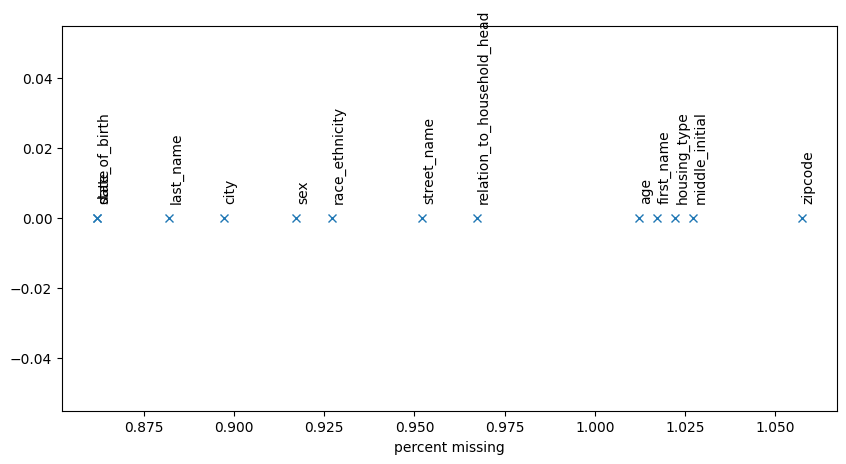

In [30]:
filtered_percent_missing = 100*filtered_missing/len(df_census)

fig, ax = plt.subplots(figsize=(10,5))
x = filtered_percent_missing
y = np.zeros_like(filtered_percent_missing)
col_name = filtered_percent_missing.index
ax.plot(x, y, 'x')
for col_name_i, xi, yi in zip(col_name, x, y+0.005):
    ax.annotate(col_name_i, (xi, yi), rotation=90)
ax.set_xlabel('percent missing')

# Try generating noised data for multiple seeds and comparing

In [31]:
%%time
seeds = range(33,43)
noised_dfs = {}
missing_counts = {}
missing_percents = {}
for seed in seeds:
    noised_dfs[seed] = pp.generate_decennial_census(census_path, seed).replace('', np.nan)
    missing_counts[seed] = noised_dfs[seed].isna().sum()
    missing_percents[seed] = 100*missing_counts[seed].drop(
        ['simulant_id', 'unit_number', 'guardian_1', 'guardian_2', 'year', 'street_number']
    ) / len(noised_dfs[seed])
    missing_percents[seed]

CPU times: user 2.88 s, sys: 156 ms, total: 3.04 s
Wall time: 3.05 s


In [32]:
missing_percents[seed]

middle_initial                1.037386
state                         1.057432
age                           0.997294
housing_type                  1.077478
city                          0.947179
date_of_birth                 1.117570
relation_to_household_head    0.947179
sex                           0.992282
zipcode                       0.967225
race_ethnicity                0.861983
last_name                     0.987271
street_name                   0.922121
first_name                    1.057432
dtype: float64

# Write a function to draw the 1-D percent missing plot like above

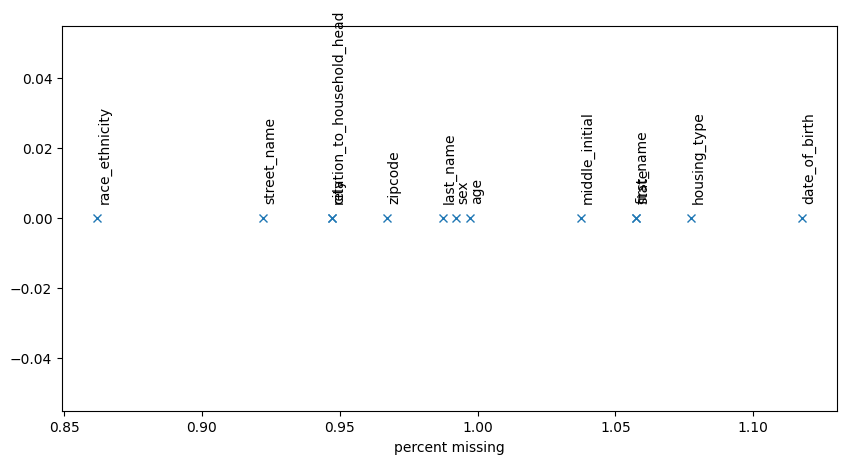

In [33]:
def plot_percent_missing(percent_missing, ax=None):
    if ax is None:
        ax = plt.gca()
    x = percent_missing
    y = np.zeros_like(percent_missing)
    col_name = percent_missing.index
    ax.plot(x, y, 'x')
    for col_name_i, xi, yi in zip(col_name, x, y+0.005):
        ax.annotate(col_name_i, (xi, yi), rotation=90)
    ax.set_xlabel('percent missing')
    
fig, ax = plt.subplots(figsize=(10,5))
plot_percent_missing(missing_percents[seed], ax)

# Draw plots for all the seeds

Ok good, it looks like the missing percentages are varying between about .85% and 1.15%, and no column is consistenty high or low between seeds.

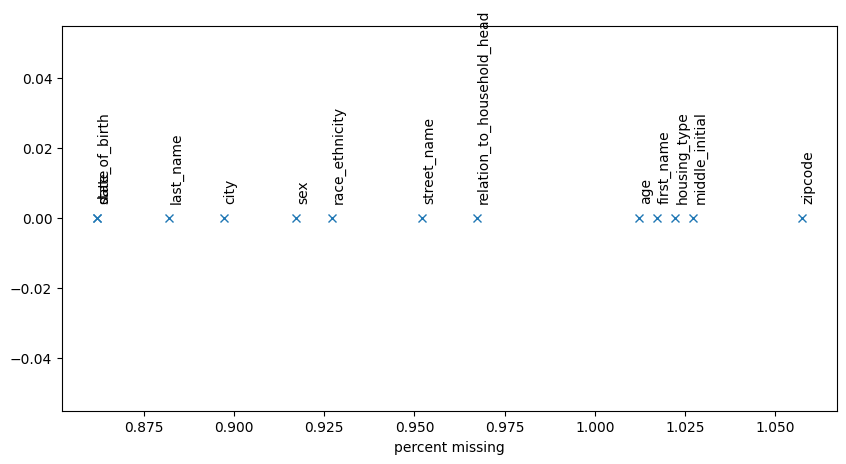

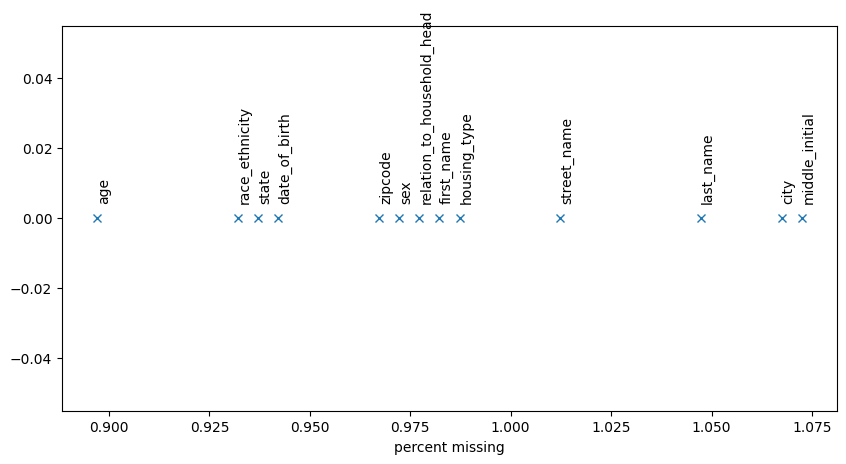

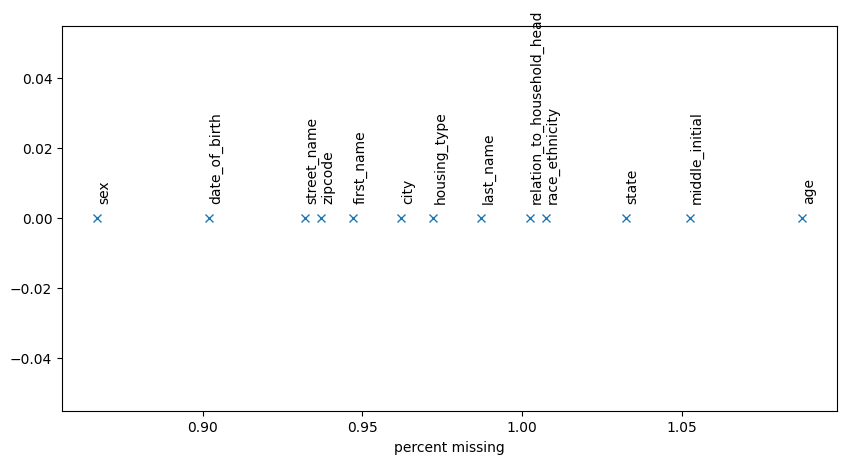

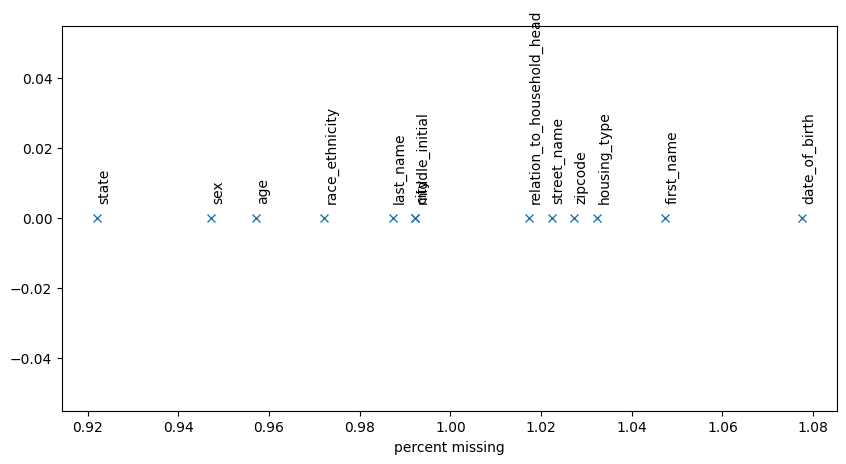

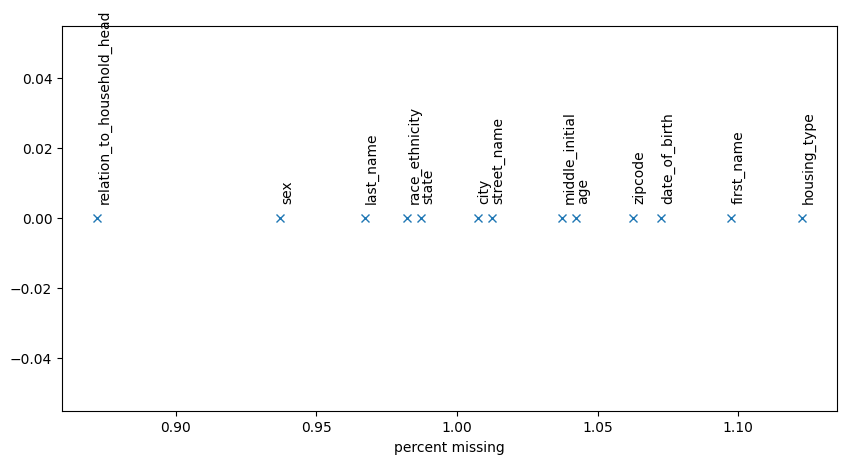

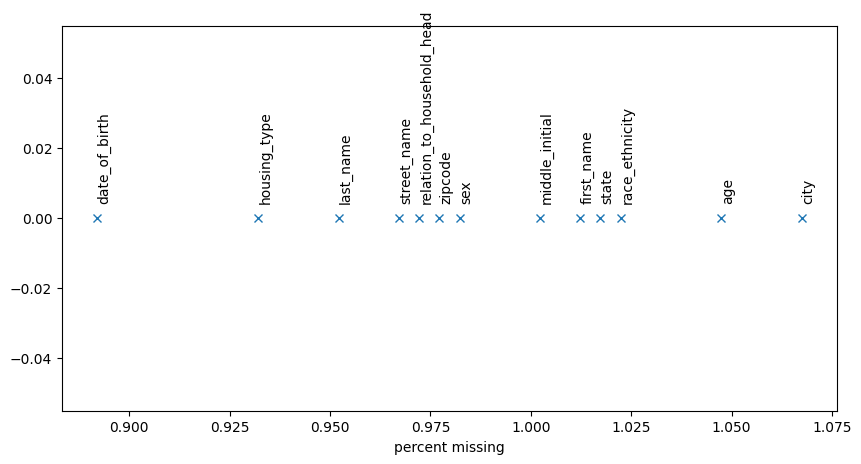

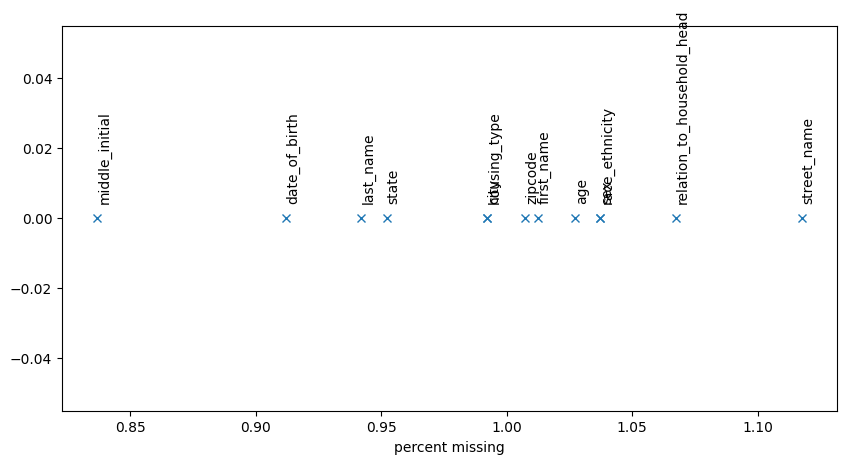

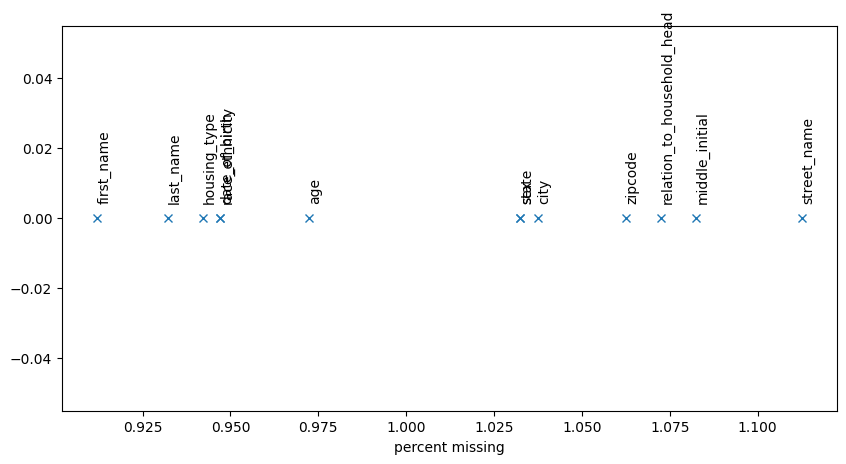

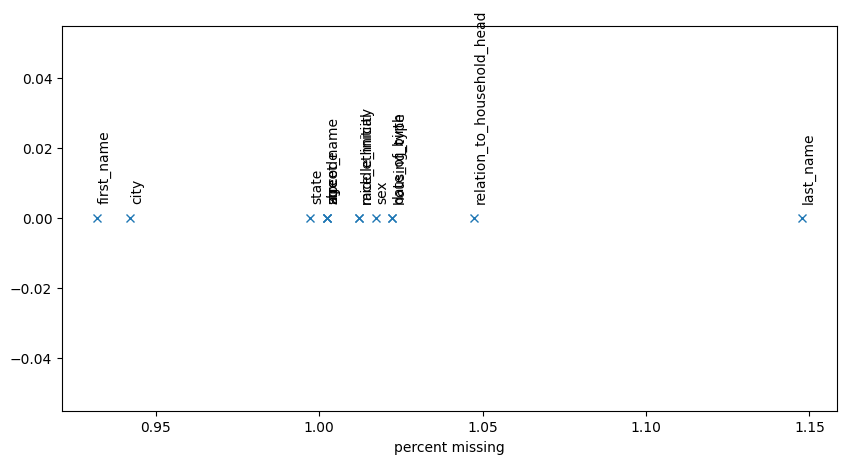

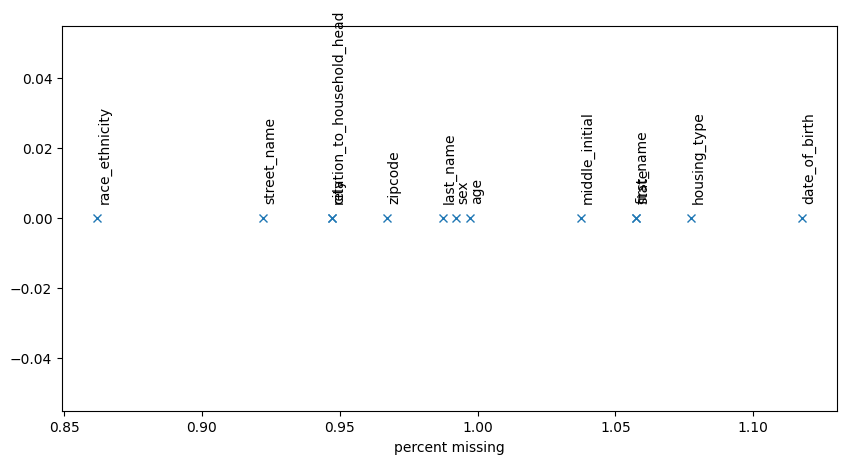

In [34]:
for seed in seeds:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_percent_missing(missing_percents[seed], ax)

# Now try it on a bigger dataset

```
/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
```

In [35]:
swe_project_dir = \
    '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
swe_output_subdir = (
    'results/vv_tax_observers'
    '/united_states_of_america/2023_03_06_12_42_55'
    '/final_results/2023_03_14_16_41_22'
)
swe_output_dir = f'{swe_project_dir}/{swe_output_subdir}'

!ls -halt $swe_output_dir

total 14G
drwxrwsr-x  2 albrja IHME-Simulationscience 4.0K Mar 22 16:44 .
-rw-r--r--  1 albrja IHME-Simulationscience  59M Mar 15 10:01 wic_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 1.5G Mar 15 10:01 tax_dependents_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.8G Mar 15 09:57 tax_w2_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 4.1G Mar 15 09:56 tax_1040_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 192M Mar 15 09:48 social_security_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience  35M Mar 15 09:36 household_survey_observer_cps.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.7M Mar 15 09:36 household_survey_observer_acs.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 638M Mar 15 09:36 decennial_census_observer.csv.bz2
drwxrwsr-x 12 albrja IHME-Simulationscience 5.5K Mar 14 20:25 ..


In [36]:
swe_census_path = f'{swe_output_dir}/decennial_census_observer.csv.bz2'

In [37]:
%%time
df_census_big = pd.read_csv(swe_census_path)
df_census_big

CPU times: user 2min 31s, sys: 6.74 s, total: 2min 38s
Wall time: 2min 39s


,middle_initial,census_year,zipcode,housing_type,simulant_id,guardian_1,race_ethnicity,date_of_birth,last_name,first_name,age,street_name,city,guardian_2,relation_to_household_head,sex,unit_number,street_number,state
0,M,2020,77566.0,Standard,2284_0,2284_-1,Latino,1982-02-09,Ticas,Michael,38.141742,adams st,sour lake,2284_-1,Reference person,Male,NaN,7136,TX
1,M,2020,77566.0,Standard,2284_1,2284_-1,Latino,1983-09-02,Ticas,Melissa,36.580000,adams st,sour lake,2284_-1,Opp-sex spouse,Female,NaN,7136,TX
2,L,2020,77566.0,Standard,2284_2,2284_0,Latino,2007-10-04,Ticas,Martin,12.492590,adams st,sour lake,2284_1,Biological child,Male,NaN,7136,TX
3,L,2020,77566.0,Standard,2284_3,2284_0,Latino,2011-11-09,Ticas,Maya,8.392918,adams st,sour lake,2284_1,Biological child,Female,NaN,7136,TX
4,M,2020,22209.0,Standard,2284_4,2284_-1,White,1960-01-28,Sayah,Randy,60.175473,north burgher avenue,leesburg,2284_-1,Reference person,Male,NaN,10233,VA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20599339,R,2030,91801.0,Standard,7359_1178694,7359_1178691,Asian,2021-04-25,Cohan,Brayden,8.976745,river rd,brentwood,7359_1178692,Biological child,Male,NaN,NaN,CA
20599340,C,2030,2151.0,Standard,7359_1178695,7359_-1,White,1999-04-24,Nethken,Jonathan,30.981676,se wst rd,cotuit,7359_-1,Reference person,Male,NaN,10531,MA
20599341,K,2030,2151.0,Standard,7359_1178696,7359_-1,White,1997-04-01,Nethken,Nicole,33.043305,se wst rd,cotuit,7359_-1,Opp-sex spouse,Female,NaN,10531,MA
20599342,A,2030,2151.0,Standard,7359_1178697,7359_1178695,White,2025-03-24,Nethken,Sage,5.064985,se wst rd,cotuit,7359_1178696,Biological child,Female,NaN,10531,MA


In [38]:
sizemb(df_census_big) # 21 GB

21083.217744

In [39]:
(df_census_big == '').any()

middle_initial                False
census_year                   False
zipcode                       False
housing_type                  False
simulant_id                   False
guardian_1                    False
race_ethnicity                False
date_of_birth                 False
last_name                     False
first_name                    False
age                           False
street_name                   False
city                          False
guardian_2                    False
relation_to_household_head    False
sex                           False
unit_number                   False
street_number                 False
state                         False
dtype: bool

# Generate a noisy census from the larger data

In [40]:
seed = 33
%time df_census_big_noisy = pp.generate_decennial_census(swe_census_path, seed)
df_census_big_noisy

CPU times: user 2min 49s, sys: 12.9 s, total: 3min 2s
Wall time: 3min 2s


,middle_initial,census_year,zipcode,housing_type,simulant_id,guardian_1,race_ethnicity,date_of_birth,last_name,first_name,age,street_name,city,guardian_2,relation_to_household_head,sex,unit_number,street_number,state
0,M,2020,77566.0,Standard,2284_0,2284_-1,Latino,1982-02-09,Ticas,Michael,38.141742,adams st,sour lake,2284_-1,Reference person,Male,NaN,7136,TX
1,M,2020,77566.0,Standard,2284_1,2284_-1,Latino,1983-09-02,Ticas,Melissa,36.58,adams st,sour lake,2284_-1,Opp-sex spouse,Female,NaN,7136,TX
2,L,2020,77566.0,Standard,2284_2,2284_0,Latino,2007-10-04,Ticas,Martin,12.49259,adams st,sour lake,2284_1,Biological child,Male,NaN,7136,TX
3,L,2020,77566.0,Standard,2284_3,2284_0,Latino,2011-11-09,Ticas,Maya,8.392918,adams st,sour lake,2284_1,Biological child,Female,NaN,7136,TX
4,M,2020,22209.0,Standard,2284_4,2284_-1,White,1960-01-28,Sayah,Randy,60.175473,north burgher avenue,leesburg,2284_-1,Reference person,Male,NaN,10233,VA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20599339,R,2030,91801.0,Standard,7359_1178694,7359_1178691,Asian,2021-04-25,Cohan,Brayden,8.976745,river rd,brentwood,7359_1178692,Biological child,Male,NaN,NaN,CA
20599340,C,2030,2151.0,Standard,7359_1178695,7359_-1,White,1999-04-24,Nethken,Jonathan,30.981676,se wst rd,cotuit,7359_-1,Reference person,Male,NaN,10531,MA
20599341,K,2030,2151.0,Standard,7359_1178696,7359_-1,White,1997-04-01,Nethken,Nicole,33.043305,se wst rd,cotuit,7359_-1,Opp-sex spouse,Female,NaN,10531,MA
20599342,A,2030,2151.0,Standard,7359_1178697,7359_1178695,White,2025-03-24,Nethken,Sage,5.064985,se wst rd,cotuit,7359_1178696,Biological child,Female,NaN,10531,MA


In [41]:
5

5

# Generate noised censuses for multiple seeds from the larger data, and compute percent missing in each

In [42]:
%%time
seeds = range(33,38)
big_noised_dfs = {}
big_missing_counts = {}
big_missing_percents = {}
for seed in seeds:
    big_noised_dfs[seed] = pp.generate_decennial_census(swe_census_path, seed).replace('', np.nan)
    big_missing_counts[seed] = big_noised_dfs[seed].isna().sum()
    big_missing_percents[seed] = 100*big_missing_counts[seed].drop(
        ['simulant_id', 'unit_number', 'guardian_1', 'guardian_2', 'census_year', 'street_number']
    ) / len(big_noised_dfs[seed])
    big_missing_percents[seed]

CPU times: user 17min 7s, sys: 1min 37s, total: 18min 44s
Wall time: 18min 44s


In [43]:
340/10 * 21 # Estimated memory usage of full decennial census with 340 million population = 714 GB

714.0

# Plot percent missing in bigger dataset for multiple seeds

CPU times: user 67.7 ms, sys: 8.32 ms, total: 76 ms
Wall time: 73.1 ms


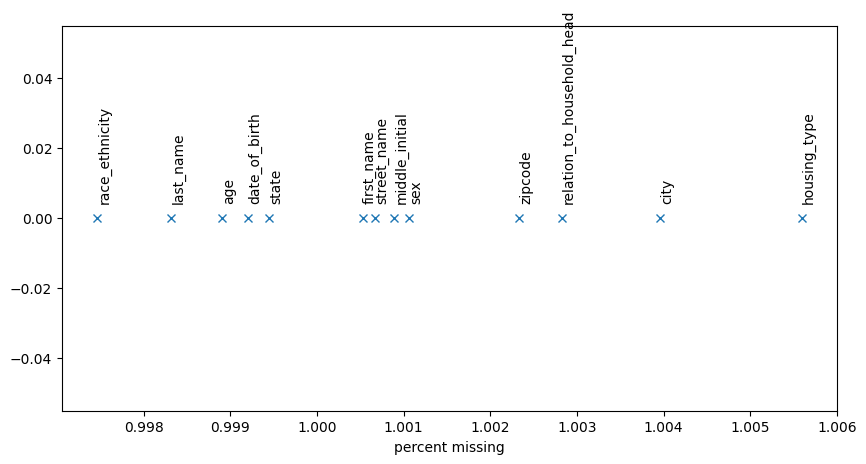

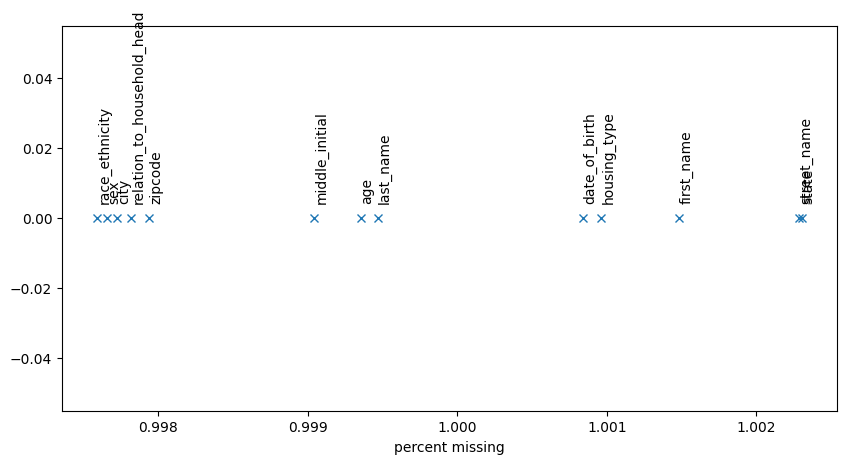

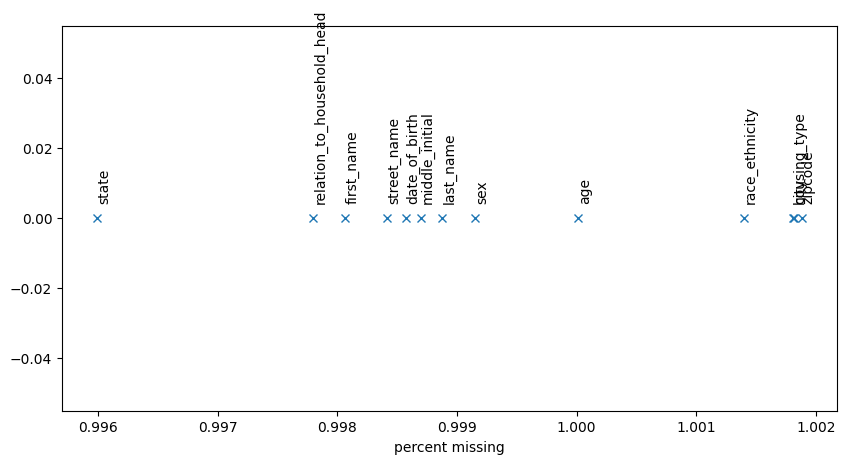

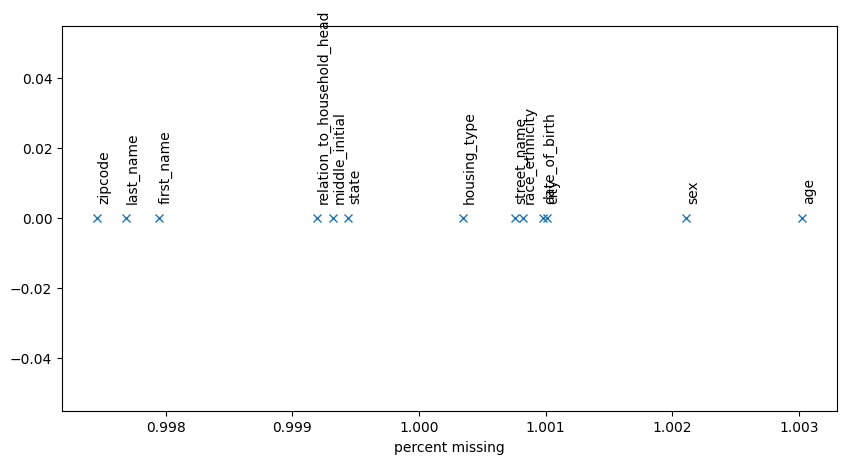

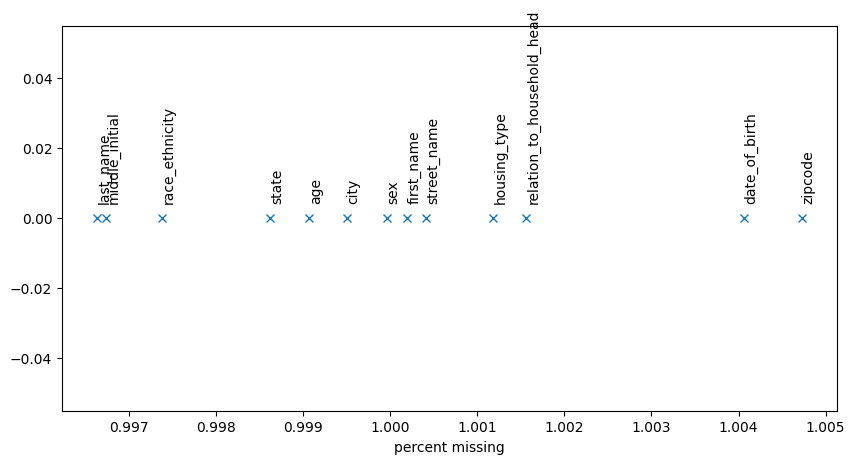

In [44]:
%%time
for seed in seeds:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_percent_missing(big_missing_percents[seed], ax)

# Plot Binomial distribution of how many missing values we expect to see 

In [45]:
from scipy import stats

In [46]:
n1 = len(df_census)
binom1 = stats.binom(n1, 0.01)
binom1.args

(19954, 0.01)

In [52]:
binom1.stats()

(array(199.54), array(197.5446))

In [47]:
filtered_missing

middle_initial                205
state                         172
age                           202
housing_type                  204
city                          179
date_of_birth                 172
relation_to_household_head    193
sex                           183
zipcode                       211
race_ethnicity                185
last_name                     176
street_name                   190
first_name                    203
dtype: int64

In [48]:
filtered_missing.describe()

count     13.000000
mean     190.384615
std       13.604769
min      172.000000
25%      179.000000
50%      190.000000
75%      203.000000
max      211.000000
dtype: float64

In [73]:
%autoreload 0

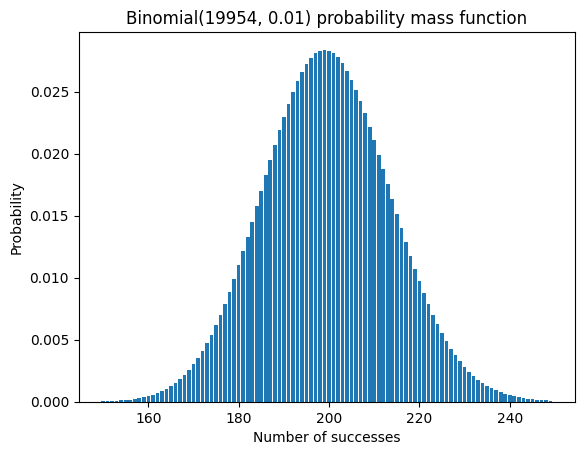

In [83]:
x = np.arange(150, 250)
plt.bar(x, binom1.pmf(x), label=f"Binom{binom1.args} PMF")
plt.title(f"Binomial{binom1.args} probability mass function")
plt.xlabel("Number of successes")
plt.ylabel("Probability");
# plt.legend()

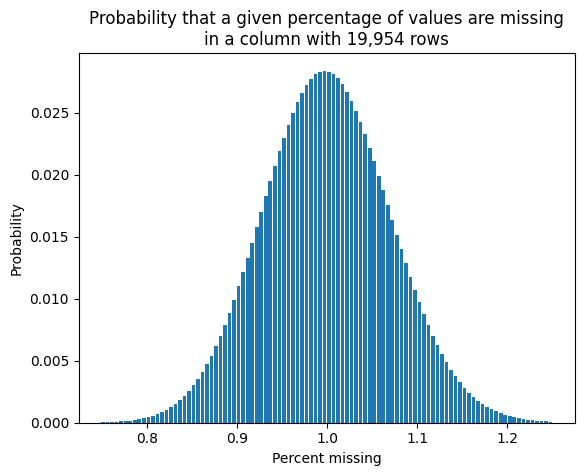

In [81]:
plt.bar(100*x/n1, binom1.pmf(x), width=100*0.8/n1)
plt.title(f"Probability that a given percentage of values are missing\nin a column with {n1:,} rows")
plt.xlabel("Percent missing")
plt.ylabel("Probability");

# Looks like we'd need the normal approximation to do the same thing for the larger dataset to avoid floating point underflow...

In [61]:
n2 = len(df_census_big)
binom2 = stats.binom(n2, 0.01)
binom2.args

(20599344, 0.01)

In [64]:
big_missing_percents[33].describe()

count    13.000000
mean      1.000862
std       0.002324
min       0.997464
25%       0.999207
50%       1.000673
75%       1.002333
max       1.005595
dtype: float64

In [65]:
big_missing_percents[33].min(), big_missing_percents[33].max()

(0.9974638027308054, 1.0055951296313126)

In [67]:
a = np.array([0.9974638027308054, 1.0055951296313126]) * n2
a

array([20547100., 20714600.])

In [68]:
a[1]-a[0]

167500.0

In [71]:
20_599_344
x = np.arange(20_599_300, 20_599_400)
plt.bar(x, binom2.pmf(x))

FloatingPointError: underflow encountered in _binom_pdf